# Obtaining Data

In [1]:
#Importing libraries needed
import pandas as pd
import numpy as np


#For graphing 
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

# For our modeling steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance

# For demonstrative pruposes
from scipy.special import logit, expit

import warnings
warnings.filterwarnings('ignore')

In [2]:
#opening the datasets 
bottom =  pd.read_csv(r'data\bottom_hurricane.csv')
middle =  pd.read_csv(r'data\middle_hurricane.csv')
top =  pd.read_csv(r'data\top_hurricane.csv')
all_df = pd.read_csv(r'data\all_hurricane.csv')

# Data Processing

In [3]:
#let's get rid of duplicate cities by only grabbing the cities with the max value for AWND
bottom = bottom.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
middle = middle.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
top = top.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
all_df = all_df.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City', 'DATE']).sort_index()

In [4]:
#We want to use data from hurricane Ian to test our mode
#let's save a dataframe that has just Ian 
all_ian = all_df.loc[all_df['HurricaneName'] == 'ian']
all_ian.head()

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
3,Apalachicola,ian,9/28/2022,38.027300,57.93571,12877,65287.07867,76710.34737,17.496982,1
98,Fort Pierce,ian,9/28/2022,50.039453,100.66050,529,79706.02938,93971.25035,17.897292,1
179,Lakeland,ian,9/28/2022,51.538176,105.13430,105,92333.43871,109089.32580,18.147149,1
188,Leesburg,ian,9/29/2022,48.540730,91.48921,1024,89188.23594,102166.59930,14.551654,1
203,Miami,ian,9/28/2022,41.539233,69.56759,20,187941.97110,204898.39500,9.022159,0


In [5]:
#removing ian from the other datasets
bottom = bottom.drop(bottom[bottom['HurricaneName'] == 'ian'].index)
middle = middle.drop(middle[middle['HurricaneName'] == 'ian'].index)
top = top.drop(top[top['HurricaneName'] == 'ian'].index)
all_df = all_df.drop(all_df[all_df['HurricaneName'] == 'ian'].index)

## Comparing Crosstabs by Target Variable

### Bottom Tier Home Values

In [6]:
#check crosstabs 
bottom[bottom['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0
mean,16.828333,31.587500,778.479167,95519.992225,109226.353419,15.737500,0.0
std,7.510509,13.880939,1933.043703,36589.222256,38580.694737,7.428945,0.0
min,4.700000,0.000000,12.000000,35072.914710,42936.584540,1.715556,0.0
25%,12.750000,23.000000,109.000000,67085.771493,77117.054463,9.294061,0.0
50%,14.430000,26.950000,219.000000,87921.154230,106197.766650,13.545954,0.0
75%,19.460000,36.000000,714.000000,124777.238250,137188.222700,21.427859,0.0
max,40.260000,79.000000,12877.000000,187941.971100,204898.395000,31.148843,0.0


In [7]:
#check crosstabs 
bottom[bottom['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,45.00000,45.000000,45.000000,45.000000,45.000000,45.000000,45.0
mean,19.71000,36.360000,1614.733333,81869.675339,99918.350911,22.208175,1.0
std,7.55599,14.072933,3251.236781,22972.899025,28216.775660,6.973273,0.0
min,5.82000,13.000000,12.000000,33025.679010,41196.088340,12.376811,1.0
25%,13.87000,25.900000,105.000000,65732.062590,78209.741850,17.496982,1.0
50%,19.46000,31.100000,350.000000,79706.029380,97547.957590,19.823318,1.0
75%,23.71000,52.100000,1343.000000,94132.640630,113361.292200,24.912005,1.0
max,40.71000,70.900000,12877.000000,137614.499600,166366.441400,38.720009,1.0


### Middle Tier Home Values

In [8]:
#check crosstabs 
middle[middle['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0
mean,17.192736,32.578302,1196.764151,178788.700647,200015.445600,12.739620,0.0
std,7.398756,13.286456,2875.059325,57253.054213,60012.616564,8.166830,0.0
min,4.700000,10.100000,12.000000,47433.413480,55475.026340,-0.304135,0.0
25%,12.750000,23.900000,106.000000,140195.814075,158385.796575,6.516116,0.0
50%,14.760000,29.100000,219.000000,168077.713500,188779.652850,10.175417,0.0
75%,20.525000,36.900000,744.000000,214175.896200,235810.160275,19.340890,0.0
max,38.920000,79.000000,12877.000000,328091.109800,346404.378100,30.423110,0.0


In [9]:
#check crosstabs 
middle[middle['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.0
mean,19.468182,33.951515,2376.212121,152609.677086,183012.972018,19.750077,1.0
std,9.052282,16.306749,3966.086317,45215.695236,58301.939354,9.054438,0.0
min,4.470000,0.000000,12.000000,38971.285380,48205.342730,8.693131,1.0
25%,13.650000,23.900000,299.000000,131341.028200,147305.080700,11.724797,1.0
50%,16.780000,30.000000,529.000000,153995.650000,185899.410500,14.943632,1.0
75%,24.610000,46.100000,1644.000000,184197.828400,211150.410200,27.524342,1.0
max,40.710000,70.900000,12877.000000,237636.125500,316361.491800,34.925821,1.0


### Top Tier Home Values

In [10]:
#check crosstabs 
top[top['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.0
mean,17.763947,33.115789,1225.184211,328449.969281,360988.239664,10.473163,0.0
std,7.852753,13.802145,2961.979981,113947.912364,122569.498236,8.631772,0.0
min,4.470000,8.100000,12.000000,98118.000900,119490.997200,-4.161603,0.0
25%,12.970000,23.900000,93.000000,246799.050675,271226.589675,4.737962,0.0
50%,15.100000,29.100000,190.000000,315968.313150,350767.209850,5.958488,0.0
75%,20.800000,38.000000,744.000000,382389.195500,418708.970725,17.504185,0.0
max,40.260000,79.000000,12877.000000,671004.028700,768214.341700,27.655345,0.0


In [11]:
#check crosstabs 
top[top['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.0
mean,17.624286,32.192857,2354.142857,273379.316779,326346.226943,18.132019,1.0
std,7.603506,14.464181,3809.242403,76774.203448,110181.403979,10.229255,0.0
min,5.820000,13.000000,16.000000,130756.896600,140391.373400,6.722834,1.0
25%,13.142500,23.675000,299.000000,231229.432300,255309.653800,7.967553,1.0
50%,14.875000,28.000000,636.500000,252692.063600,311156.525200,18.205906,1.0
75%,21.922500,34.325000,1927.000000,315217.170000,372749.758575,28.046185,1.0
max,40.710000,70.900000,12877.000000,457389.673300,605350.754900,33.863819,1.0


### All Home Values 

In [12]:
#check crosstabs 
all_df[all_df['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.0
mean,13.768992,27.177907,1191.391473,212575.987928,234000.852403,11.890184,0.0
std,6.939955,12.531378,2873.375161,124254.783285,131099.520669,8.078201,0.0
min,2.910000,0.000000,12.000000,45314.651590,52157.021900,-4.161603,0.0
25%,8.720000,18.100000,106.000000,117276.771100,135580.557625,5.582217,0.0
50%,12.190000,23.900000,219.000000,184998.996100,205368.325550,9.188158,0.0
75%,16.722500,31.100000,744.000000,278446.944025,311384.740025,17.445984,0.0
max,38.920000,79.000000,12877.000000,638691.713200,669502.004200,30.676022,0.0


In [13]:
#check crosstabs 
all_df[all_df['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.0
mean,14.880814,27.886047,1861.965116,146638.094252,174430.381725,19.463055,1.0
std,7.205503,13.217672,3396.683491,83327.546857,100276.415300,8.625308,0.0
min,4.920000,6.900000,12.000000,44457.567490,55432.846820,6.722834,1.0
25%,9.282500,18.100000,107.750000,80030.413350,93270.193108,12.500773,1.0
50%,13.650000,24.500000,462.000000,126538.414750,148023.322150,17.719562,1.0
75%,18.570000,31.775000,1410.000000,190034.211300,219513.525825,25.149288,1.0
max,40.710000,70.900000,12877.000000,372909.443500,488064.017600,38.720009,1.0


# Baseline Model

## Examining Class Imbalance

In order to know what a good accuracy is for our models, we must know what the majority class percent is. This will tell us if our model performs any better than just selecting the majority class each time. 

|Dataset | Increase | No Increase | No Increase as Percent |
|---|---|---|---|
|Bottom Tier| 45 | 96| 68% |
|Middle Tier| 33 | 106 | 76% |
|Top Tier| 28 | 114 | 80% |
|All| 89 | 255 | 74% |

#### Bottom Tier Class Imabalance

0    96
1    45
Name: increase, dtype: int64
majority percent is 68.08510638297872 %


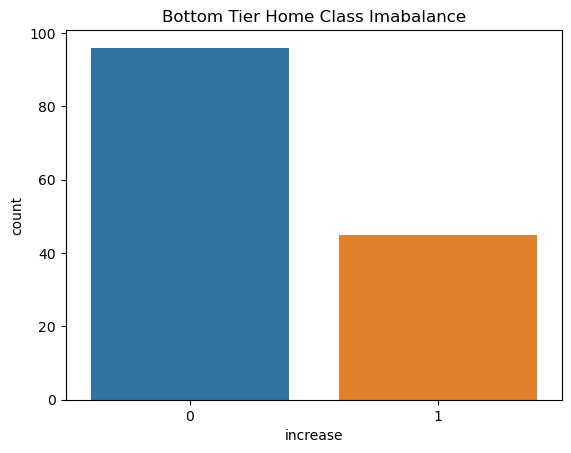

In [14]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=bottom).set(title='Bottom Tier Home Class Imabalance')
print(bottom['increase'].value_counts())
#checking ratio to see what accuracy is like
percent_bottom = (len(bottom['increase']) - bottom['increase'].sum())/(len(bottom['increase']) - bottom['increase'].sum()+bottom['increase'].sum())*100
print("majority percent is {}".format(percent_bottom),"%")


#### Middle Tier Class Imbalance

0    106
1     33
Name: increase, dtype: int64
majority percent is 76.2589928057554 %


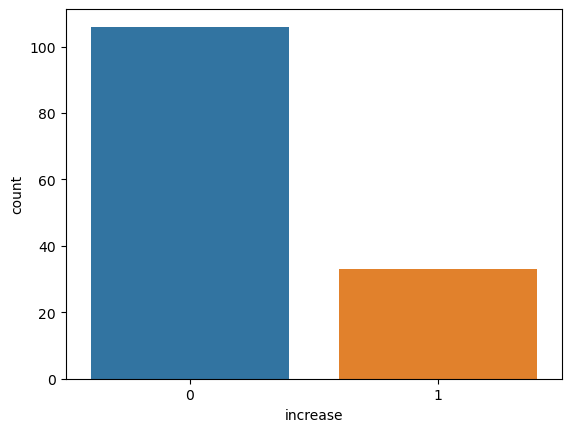

In [15]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=middle);
print(middle['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(middle['increase']) - middle['increase'].sum())/(len(middle['increase']) - middle['increase'].sum()+middle['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

#### Top Tier Class Imbalance

0    114
1     28
Name: increase, dtype: int64
majority percent is 80.28169014084507 %


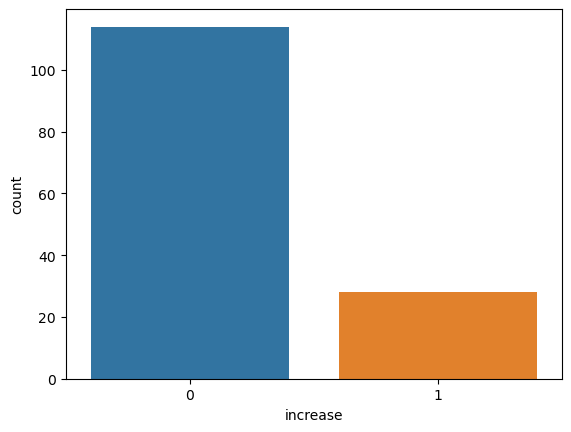

In [16]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=top);
print(top['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(top['increase']) - top['increase'].sum())/(len(top['increase']) - top['increase'].sum()+top['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### All Homes Class Imbalance

0    258
1     86
Name: increase, dtype: int64
majority percent is 75.0 %


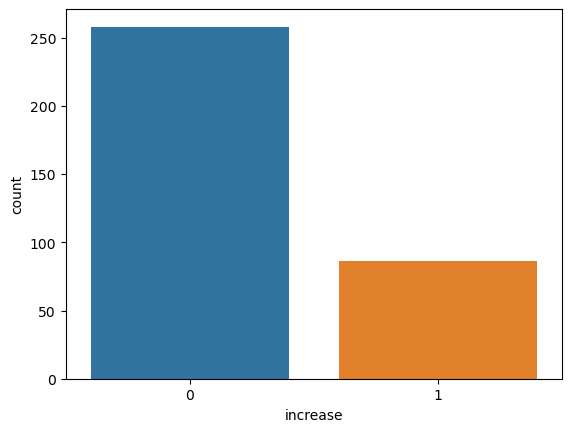

In [17]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=all_df);
print(all_df['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all_df['increase']) - all_df['increase'].sum())/(len(all_df['increase']) - all_df['increase'].sum()+all_df['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

# Modeling 

For the scope of this project we will be using accuracy and F1 score to assess our model performance. Since we had a class imbalance we could not solely rely on accuracy to communicate model performance. Since, precision and recall were of equal importance for our business problem F1 score was used to assess model performance. 

- **Model accuracy** is a machine learning classification model performance metric that takes the ratio of true positives and true negatives to all positives and negative results. It communicates how often our model will correctly predict an outcome out of the total number of predictions made. However, accuracy metrics are not always reliable for imbalance datasets. Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)  

- **Model F1 Score** is a model performance metric that gives equal weight to both the Precision and Recall for measuring performance. F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)    

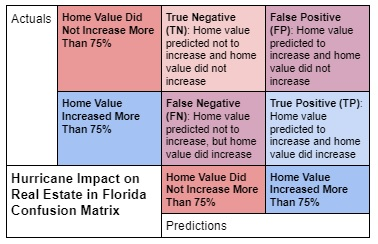

**Works Cited**   
Kumar A. Accuracy, Precision, Recall & F1-Score - Python Examples. Data Analytics. Published October 1, 2021. https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

### Logistic Regresion

A logistic regression model was iterated through with our scaled data. We removed collinear variables and used SMOTE to adjust for the class imbalance. The logistic regression model that performed the best was our SMOTE model with no colinear features and had an accuracy of 0.74 which was slightly better than our baseline accuracy of 0.68 and an F1 score of 0.68. 

In [18]:
#establishing model 
logreg = LogisticRegression(random_state=56)

## Model 1: Bottom Tier Housing

We will use the bottom tier housing for modeling since it has the best class imbalance. 

### Selecting Our Target Variable and Features
Our targer variable is increase and for our first iteration of modeling we will use all the available features. 

In [19]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

### Train/Test Split

In [20]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [21]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### Training Data

In [22]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [23]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.684


In [24]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.311


### Testing Data

In [25]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [26]:
#Printing Accuracy
accuracy_1 = accuracy_score(y_test, y_pred_test)
print(accuracy_1)

0.7441860465116279


In [27]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_1 = f1_score(y_test, y_pred_test)
print(F1_1)

0.35294117647058826


In [28]:
#initiating dictionary to keep model accuracy and F1 score
model_dict = {}
#recording baseline model accuracy
model_dict['Baseline Accuracy'] = percent_bottom
#recording model 1 values
model_dict['LGRModel1_Accuracy'] = accuracy_1
model_dict['LGRModel1_F1'] = F1_1
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826}

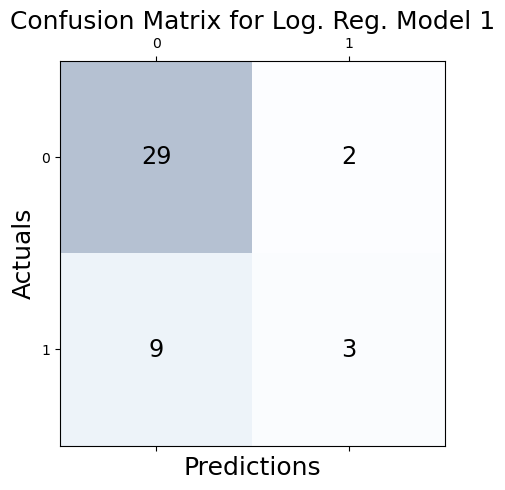

In [29]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Log. Reg. Model 1', fontsize=18)
plt.show()

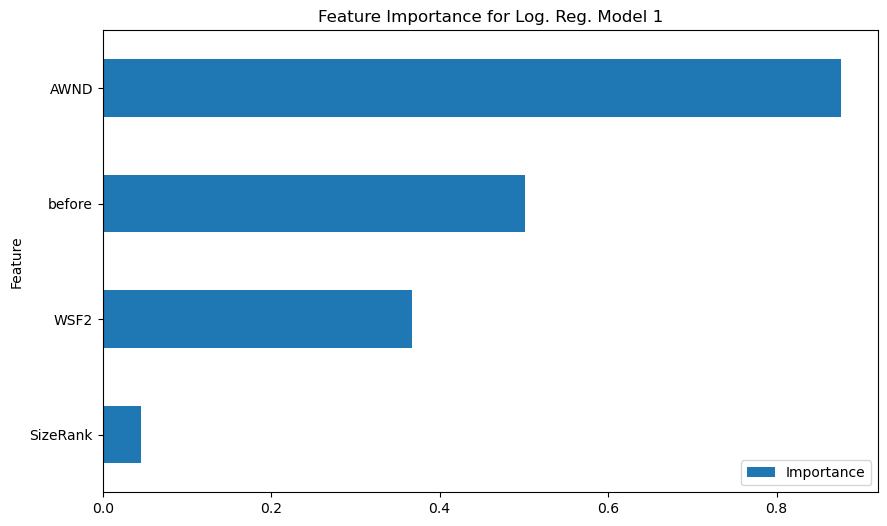

In [30]:
#https://forecastegy.com/posts/feature-importance-in-logistic-regression/#feature-importance-in-binary-logistic-regression
#checking out feature importance

model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', title='Feature Importance for Log. Reg. Model 1', kind='barh', figsize=(10, 6));

## Model 2: Bottom Tier Housing Without Colinear Variables 

We will use the bottom tier housing for modeling since it has the best class imbalance. 

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [31]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

### Train/Test Split

In [32]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [33]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### Training Data

In [34]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [35]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.684


In [36]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.311


### Testing Data

In [37]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [38]:
#Printing Accuracy
accuracy_2 = accuracy_score(y_test, y_pred_test)
print(accuracy_2)

0.7674418604651163


In [39]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_2 = f1_score(y_test, y_pred_test)
print(F1_2)

0.375


### Saving to Dictionary

In [40]:
#adding to model dictionary
model_dict['LGRModel2_Accuracy'] = accuracy_2
model_dict['LGRModel2_F1'] = F1_2
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375}

### Confusion Matrix

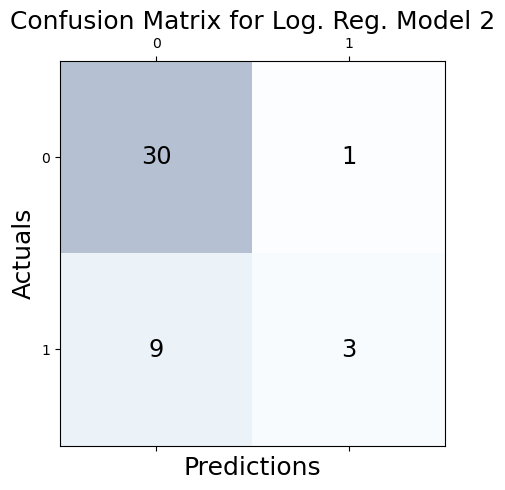

In [41]:
#plotting confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Log. Reg. Model 2', fontsize=18)
plt.show()

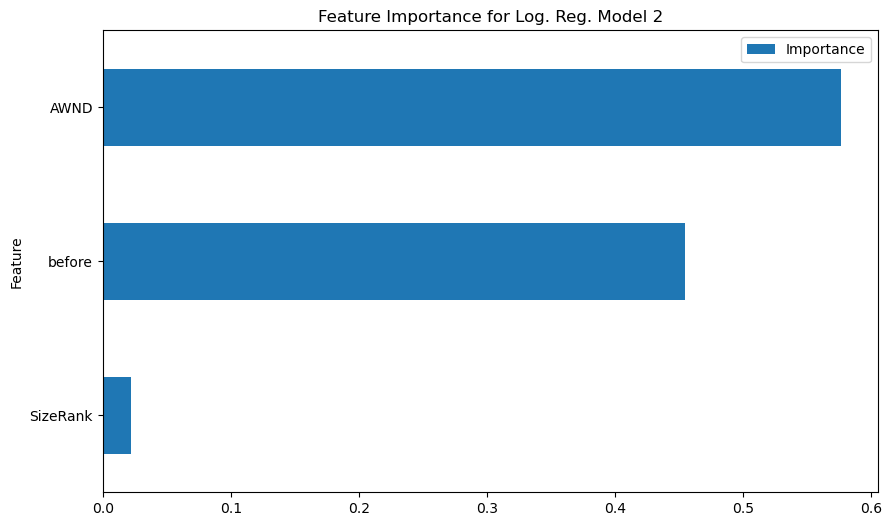

In [42]:
model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', title= 'Feature Importance for Log. Reg. Model 2', figsize=(10, 6));

## Model 3: Bottom Tier Housing with Smote 

In [43]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase', 'WSF2'], axis=1)

### Train/Test Split

In [44]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [45]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### SMOTE

In [46]:
# Create instance of smotec
from imblearn.over_sampling import SMOTE,SMOTENC
# set sampling_strategy to 0.8 to avoid oversampling
smote = SMOTE(sampling_strategy=0.8, random_state=56)

In [47]:
# Create resampled version of the train dataset
SMOTE_X_train, SMOTE_y_train = smote.fit_resample(X_train, y_train)
# Create resampled version of the test dataset
SMOTE_X_test, SMOTE_y_test = smote.fit_resample(X_test, y_test)

In [48]:
#before smote
print('Before Smote\n', y_train.value_counts())

#after smote
print('\nAfter Smote\n', SMOTE_y_train.value_counts())

Before Smote
 0    65
1    33
Name: increase, dtype: int64

After Smote
 0    65
1    52
Name: increase, dtype: int64


### Training Data

In [49]:
#fitting the model unto our training data
logreg.fit(SMOTE_X_train, SMOTE_y_train)
y_pred_train = logreg.predict(SMOTE_X_train)

In [50]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(SMOTE_y_train, y_pred_train))

Accuracy: 0.641


In [51]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(SMOTE_y_train, y_pred_train))

F1 Score: 0.553


### Testing Data

In [52]:
#fitting the model unto our test data
logreg.fit(SMOTE_X_test, SMOTE_y_test)
y_pred_test = logreg.predict(SMOTE_X_test)

In [53]:
#Printing Accuracy
accuracy_3 = accuracy_score(SMOTE_y_test, y_pred_test)
print(accuracy_3)

0.7454545454545455


In [54]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_3 = f1_score(SMOTE_y_test, y_pred_test)
print(F1_3)

0.6818181818181818


In [55]:
model_dict['LGRModel3_Accuracy'] = accuracy_3
model_dict['LGRModel3_F1'] = F1_3
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818}

### Confusion Matrix

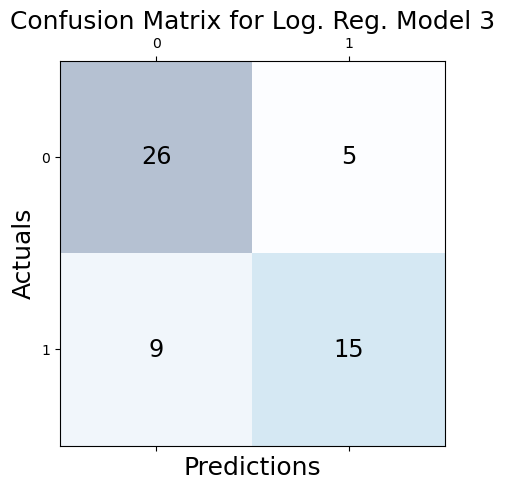

In [56]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=SMOTE_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Log. Reg. Model 3', fontsize=18)
plt.show()

### Feature Importance

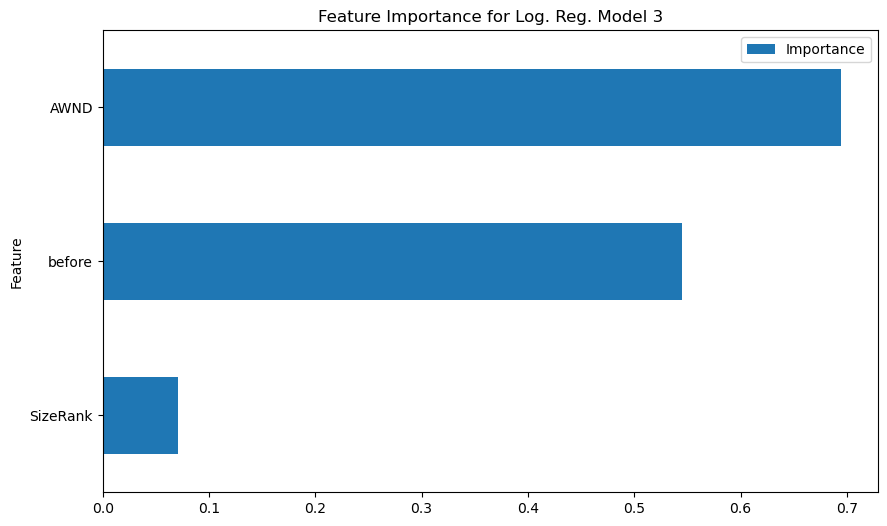

In [57]:
model = LogisticRegression()
model.fit(SMOTE_X_train, SMOTE_y_train)

coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', title= 'Feature Importance for Log. Reg. Model 3', figsize=(10, 6));

## XGBoost

In [58]:
#initiating model
xgb = xgb.XGBClassifier(random_state=56)

### Selecting Our Target Variable and Features

In [59]:
#y is prediction variable 
#X is features 
y_boost = bottom['increase']
X_boost = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)


### Train/Test Split

In [60]:
#train/test splits with 30% test size
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

### Training Data

In [61]:
xgb.fit(XG_X_train, XG_y_train);

In [62]:
y_pred_train = xgb.predict(XG_X_train)

In [63]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 1.000


In [64]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 1.000


### Testing Data

In [65]:
xgb.fit(XG_X_test, XG_y_test);

In [66]:
y_pred_test = xgb.predict(XG_X_test)

In [67]:
#Printing Accuracy
accuracy_XG1 = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XG1)

1.0


In [68]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XG1 = f1_score(XG_y_test, y_pred_test)
print(F1_XG1)

1.0


In [69]:
model_dict['XGBoost_Accuracy'] = accuracy_XG1
model_dict['XGBoost_F1'] = F1_XG1
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0}

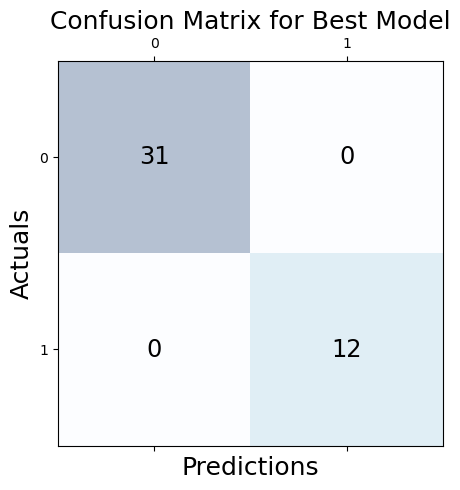

In [70]:
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Best Model', fontsize=18)
plt.show()

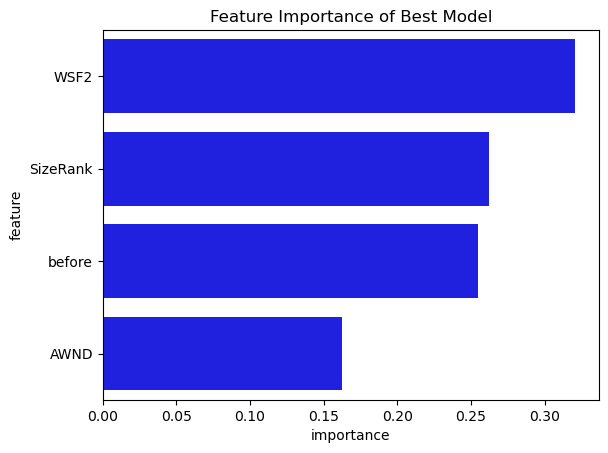

In [71]:
#seeing what features are most important to housing value
#Using feature importance 
feature_importances = xgb.feature_importances_

# Create a list of features
feature_list = list(X_boost.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)


result = relative_importances.reset_index().sort_values('importance',ascending=False)

#plot feature importances with sorted values
sns.barplot(x='importance', y="index", data=result, color='blue').set(title='Feature Importance of Best Model', ylabel = 'feature');

# How Do Wind Speed Features Impact Model Performance
For the scope of this project we are particularily interested in how hurricane's impact real estate value. Using wind speed we were able to gauge how much damage a hurricane had on a certain area. The most important feature for our best model was fastest 2 minute wind gust and SizeRank. When we drop the wind features from the model the accuracy drops to 0.95 and the F1 score drops to 0.90. 

### Selecting Our Target Variable and Features

In [72]:
#y is prediction variable 
#X is features 
y_boost = bottom['increase']
X_boost = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase', 'WSF2', 'AWND'], axis=1)


### Train/Test Split

In [73]:
#train/test splits with 30% test size
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

### Training Data

In [74]:
xgb.fit(XG_X_train, XG_y_train);

In [75]:
y_pred_train = xgb.predict(XG_X_train)

In [76]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 1.000


In [77]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 1.000


### Testing Data

In [78]:
#fitting the model 
xgb.fit(XG_X_test, XG_y_test);

In [79]:
#getting predictions 
y_pred_test = xgb.predict(XG_X_test)

In [80]:
#Printing Accuracy
accuracy_XGW = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XGW)

0.9534883720930233


In [81]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XGW = f1_score(XG_y_test, y_pred_test)
print(F1_XGW)

0.9090909090909091


In [82]:
model_dict['XGBoost_Accuracy_No_Wind'] = accuracy_XGW
model_dict['XGBoost_F1_No_Wind'] = F1_XGW
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0,
 'XGBoost_Accuracy_No_Wind': 0.9534883720930233,
 'XGBoost_F1_No_Wind': 0.9090909090909091}

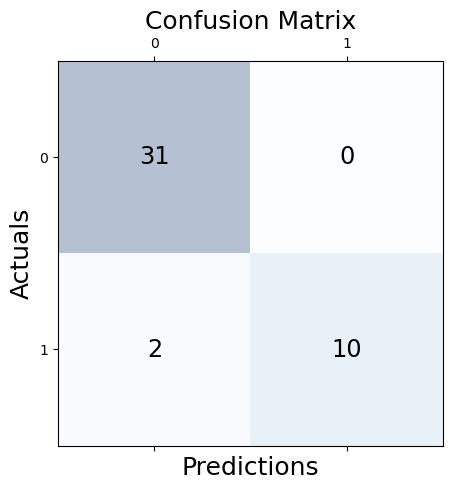

In [83]:
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

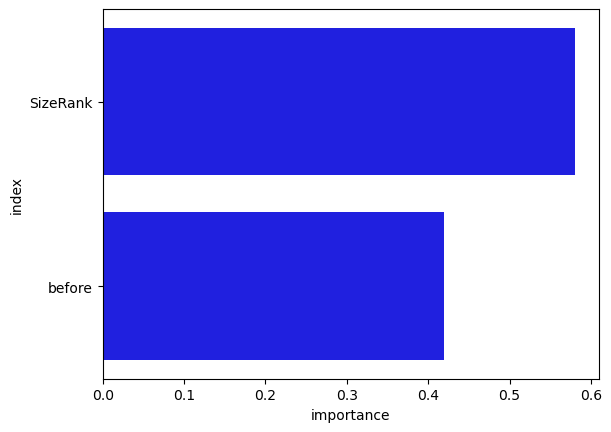

In [84]:
#seeing what features are most important to housing value
#Using feature importance 
feature_importances = xgb.feature_importances_

# Create a list of features
feature_list = list(X_boost.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)


result = relative_importances.reset_index().sort_values('importance',ascending=False)

#plot feature importances with sorted values
sns.barplot(x='importance', y="index", data=result, color='blue');

# Best Model: XGBoost
We ran two types of models, logistic regression and XG Boost. The best logisitc regression model had an accuracy of 72% which is only slightly better than the majority percent of 68%. Our best model was XGBoost which had a perfect accuracy and F1 score with the included features:
- AWND
- WSF2
- SizeRank
- before 

In [85]:
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0,
 'XGBoost_Accuracy_No_Wind': 0.9534883720930233,
 'XGBoost_F1_No_Wind': 0.9090909090909091}

## XGBoost Hypertuning 

Even though our model is running well as is, I am curious to know what the best parameters for it are. Let's run a gridsearch. 

In [91]:
#hypertuning the model using GridSearch
xgb_grid = {
            'learning_rate': [0.01, 0.1, 0.5], 
            'gamma': [0, 0.01, 0.1], 
            'max_depth': [2, 5, 6, 10], 
            'min_child_weight': [0.1, 1, 10], 
            'subsample': [0.5, 0.7, 0.9], 
            'n_estimators': [5, 10, 20, 100]
           }

xgb_gridsearch = GridSearchCV(estimator=xgb, 
                              param_grid=xgb_grid, 
                              cv=5, 
                              return_train_score=True)

xgb_gridsearch.fit(X_boost, y_boost)

print('Best Parameters for Our XGBoost Model:')
xgb_gridsearch.best_params_

Best Parameters for Our XGBoost Model:


{'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 10,
 'n_estimators': 5,
 'subsample': 0.5}

In [97]:
pip install xgboost==1.2.0

     --------------------------------------- 86.5/86.5 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\salom\\anaconda3\\Lib\\site-packages\\~gboost\\lib\\xgboost.dll'
Consider using the `--user` option or check the permissions.



In [96]:
#Setting up classified with best parameters 
gs_xg = xgb.XGBClassifier(gamma=0, 
                               learning_rate=0.01, 
                               max_depth=2, 
                               min_child_weight=10, 
                               n_estimators=5, 
                               subsample=0.5, 
                               random_state=56)

AttributeError: 'XGBClassifier' object has no attribute 'XGBClassifier'

## XGBoost on All Data

Now that we have our model, let's see how it performs on other data. 

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [ ]:
all_df

In [ ]:
#y is prediction variable 
#X is features 
y_boost = all_df['increase']
X_boost = all_df.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

In [ ]:
#performing train test split 
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

In [ ]:
xgb.fit(XG_X_train, XG_y_train);

In [ ]:
y_pred_train = xgb.predict(XG_X_train)

In [ ]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

In [ ]:
xgb.fit(XG_X_test, XG_y_test);

In [ ]:
y_pred_test = xgb.predict(XG_X_test)

In [ ]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_test, y_pred_test))

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_test, y_pred_test))

In [ ]:
#looking at confusion matrix 
#calling confusion matrix 
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

#plotting confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

#labeling confusion matrix 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## XGBoost on Hurricane Ian Data

In [ ]:
# Checking the balance of target variable 'increase'
#plotting 
sns.countplot(x='increase', data=all_ian).set(title='Hurricane Ian Class Imbalance')
#print value counts 
print(all_ian['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all_ian['increase']) - all_ian['increase'].sum())/(len(all_ian['increase']) - all_ian['increase'].sum()+all_ian['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [ ]:
#y is prediction variable 
#X is features 
y_boost = all_ian['increase']
X_boost = all_ian.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)


In [ ]:
y_pred = xgb.predict(X_boost)

In [ ]:
#Printing Accuracy
#With Wind 78%
#Without wind 74%
print('Accuracy: %.3f' % accuracy_score(y_boost, y_pred))

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
#With Wind 0.625
#Without wind 0.588
print('F1 Score: %.3f' % f1_score(y_boost, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_true=y_boost, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Hurricane Ian', fontsize=18)
plt.show()

add classification matrix 